In [1]:
!pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import string

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

import optuna

2023-06-16 08:14:51.088762: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 08:14:51.356331: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 08:14:51.357983: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 08:14:52.770552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 5)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0., 1.0)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [3]:
train_file_path = '../raw_data/tmp_data/y_train_umbr.npy'
test_file_path = '../raw_data/tmp_data/y_test_umbr.npy'
y_train_um = np.load(train_file_path, allow_pickle=True)
y_test_um = np.load(test_file_path, allow_pickle=True)
genre_dict = pd.DataFrame(y_train_um).set_index(3)[2].to_dict()
y_train_um = np.load(train_file_path, allow_pickle=True)[:, 3].astype(int)
y_test_um = np.load(test_file_path, allow_pickle=True)[:, 3].astype(int)

In [4]:
X_train = pd.read_csv("../raw_data/train_x.csv", delimiter=" ", index_col="Id")["Title"]
y_train = pd.read_csv("../raw_data/train_y.csv", delimiter=" ", index_col="Id")['Genre_id']
X_test = pd.read_csv("../raw_data/test_x.csv", delimiter=" ", index_col="Id")["Title"]
y_test = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']

In [5]:
#load for colab
from google.colab import drive
drive.mount('/content/drive')

X_train = pd.read_csv("/content/drive/My Drive/Wagon-Book-Cover/train_x.csv", delimiter=" ", index_col="Id")["Title"]
X_test = pd.read_csv("/content/drive/My Drive/Wagon-Book-Cover/test_x.csv", delimiter=" ", index_col="Id")["Title"]

train_file_path = '/content/drive/My Drive/Wagon-Book-Cover/y_train_umbr.npy'
test_file_path = '/content/drive/My Drive/Wagon-Book-Cover/y_test_umbr.npy'
y_train_um = np.load(train_file_path, allow_pickle=True)
y_test_um = np.load(test_file_path, allow_pickle=True)
genre_dict = pd.DataFrame(y_train_um).set_index(0)[1].to_dict()
genre_dict_um = pd.DataFrame(y_train_um).set_index(3)[2].to_dict()
y_train_um = np.load(train_file_path, allow_pickle=True)[:, 3].astype(int)
y_test_um = np.load(test_file_path, allow_pickle=True)[:, 3].astype(int)
y_train = np.load(train_file_path, allow_pickle=True)[:, 0].astype(int)
y_test = np.load(test_file_path, allow_pickle=True)[:, 0].astype(int)

ModuleNotFoundError: No module named 'google.colab'

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [6]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', value=0, maxlen=40)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', value=0, maxlen=40)
X_train_pad

array([[1.2000e+01, 1.8795e+04, 1.9000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.8796e+04, 1.8797e+04, 1.2390e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0400e+02, 4.9700e+02, 3.5470e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 1.6942e+04, 6.0720e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.8430e+03, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.2650e+03, 1.4085e+04, 4.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], dtype=float32)

In [7]:
y_train_cat = to_categorical(y_train, num_classes=30)
y_test_cat = to_categorical(y_test, num_classes=30)
y_train_cat.shape

(51300, 30)

In [8]:
vocab_size = len(tokenizer.word_counts)
vocab_size

36975

In [50]:
def initialize_model():
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        output_dim=80,
        input_length=40,
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.Conv1D(50, kernel_size=5))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(40, activation="relu"))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(10, activation="relu"))
    
    model.add(layers.Dense(40, activation="relu"))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(20, activation="relu"))
    
    model.add(layers.Dense(30, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

In [51]:
model_cnn = initialize_model()

es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")

history = model_cnn.fit(X_train_pad, y_train_cat,
              epochs=1000,
              batch_size=32,
              validation_split=0.3,
              callbacks=[es]
             )


res = model_cnn.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Epoch 1/1000
1123/1123 [==============================] - 35s 28ms/step - loss: 3.2122 - accuracy: 0.0744 - val_loss: 3.7486 - val_accuracy: 0.0155
Epoch 2/1000
1123/1123 [==============================] - 31s 28ms/step - loss: 2.8769 - accuracy: 0.1613 - val_loss: 3.4229 - val_accuracy: 0.0806
Epoch 3/1000
1123/1123 [==============================] - 36s 32ms/step - loss: 2.5609 - accuracy: 0.2406 - val_loss: 3.2991 - val_accuracy: 0.0980
Epoch 4/1000
1123/1123 [==============================] - 33s 30ms/step - loss: 2.3309 - accuracy: 0.3035 - val_loss: 3.1070 - val_accuracy: 0.1144
Epoch 5/1000
1123/1123 [==============================] - 30s 26ms/step - loss: 2.1403 - accuracy: 0.3595 - val_loss: 3.2372 - val_accuracy: 0.1400
Epoch 6/1000
1123/1123 [==============================] - 24s 21ms/step - loss: 1.9683 - accuracy: 0.4063 - val_loss: 3.1035 - val_accuracy: 0.1619
Epoch 7/1000
1123/1123 [==============================] - 29s 26ms/step - loss: 1.8075 - accuracy: 0.4580 - val_

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

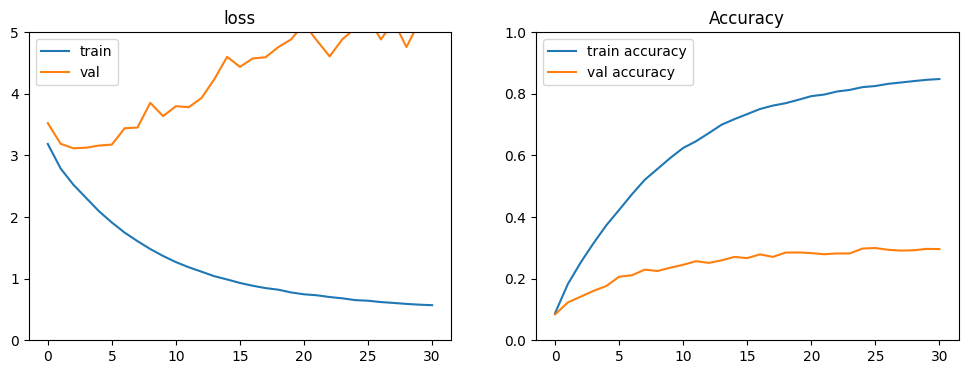

In [48]:
plot_history(history)


179/179 [==============================] - 2s 9ms/step


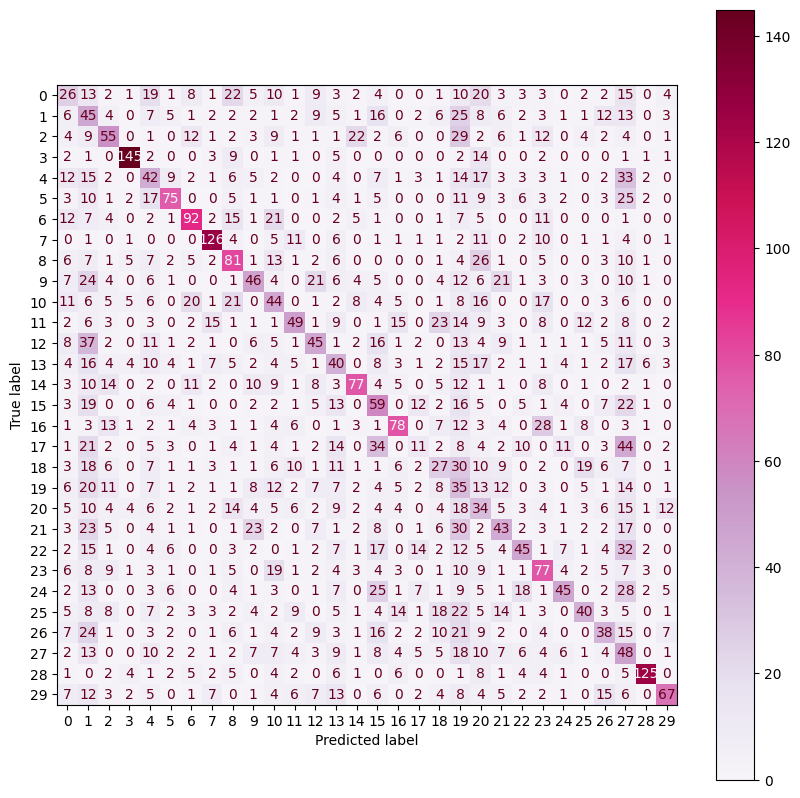

In [49]:
y_pred = np.argmax(model_cnn.predict(X_test_pad), axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

In [17]:
f1_score(y_test, y_pred, average="macro")

0.46859288270640675

In [19]:
from tensorflow.keras import Model

In [24]:
embedding_model = Model(inputs=model_cnn.input, outputs=model_cnn.layers[0].output)


embedding_train_output = embedding_model.predict(X_train_pad)
#embedding_train_output_2d = embedding_train_output.reshape(embedding_train_output.shape[0], -1)
#embedding_train_df = pd.DataFrame(embedding_train_output_2d)


embedding_test_output = embedding_model.predict(X_test_pad)
#embedding_test_output_2d = embedding_test_output.reshape(embedding_test_output.shape[0], -1)
#embedding_test_df = pd.DataFrame(embedding_test_output_2d)

179/179 [==============================] - 0s 1ms/step


In [25]:
embedding_train_output

array([[[ 0.0156323 , -0.06108295,  0.01486056, ..., -0.00634426,
         -0.04449   ,  0.04177163],
        [ 0.02616117, -0.03559741,  0.10443635, ..., -0.04575054,
         -0.0094737 , -0.03218604],
        [ 0.06127727, -0.05845211,  0.03150973, ..., -0.11013929,
         -0.0046988 , -0.03447853],
        ...,
        [ 0.00755692,  0.00506945, -0.00376677, ...,  0.00664866,
         -0.00373353, -0.00643786],
        [ 0.00755692,  0.00506945, -0.00376677, ...,  0.00664866,
         -0.00373353, -0.00643786],
        [ 0.00755692,  0.00506945, -0.00376677, ...,  0.00664866,
         -0.00373353, -0.00643786]],

       [[-0.09190077, -0.08695287,  0.01052384, ..., -0.04572945,
          0.02202363,  0.07886421],
        [-0.10466588, -0.02235792, -0.02657671, ..., -0.05626396,
          0.02800268,  0.02914933],
        [ 0.04478816,  0.01442525,  0.01340613, ..., -0.07507785,
         -0.01717396, -0.02622243],
        ...,
        [ 0.00755692,  0.00506945, -0.00376677, ...,  

In [31]:
np.save('../raw_data/embeded_data/embedding_train_text.npy', embedding_train_output)
np.save('../raw_data/embeded_data/embedding_test_text.npy', embedding_test_output)

In [17]:
# def create_model(trial, optimizer):
#     model = Sequential()
#     model.add(layers.Embedding(
#         input_dim=vocab_size+1,
#         output_dim=trial.suggest_int("embedding_units", 10, 100),
#         input_length=40,
#         mask_zero=True,
#     ))

#     model.add(layers.Conv1D(trial.suggest_int("conv_units", 10, 100), kernel_size=trial.suggest_int("kernel_size", 2, 7)))
        
#     model.add(layers.Flatten())

#     model.add(layers.Dense(30, activation="softmax"))

#     model.compile(loss="categorical_crossentropy", 
#                   optimizer=optimizer, 
#                   metrics=["accuracy"])

#     return model

# def objective(trial):
#     optimizer_name = trial.suggest_categorical("optimizer", ["rmsprop", "adam", "sgd"])
#     if optimizer_name == "rmsprop":
#         optimizer = RMSprop(learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True))
#     elif optimizer_name == "adam":
#         optimizer = Adam(learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True))
#     else:
#         optimizer = SGD(learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True))
        
#     model = create_model(trial, optimizer)
#     es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")
#     history = model.fit(X_train_pad, y_train_cat,
#                         epochs=1000,
#                         batch_size=16,
#                         validation_split=0.3,
#                         callbacks=[es],
#                         verbose=0)
#     return history.history["val_accuracy"][-10]

In [18]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000, n_jobs=4)

[I 2023-06-15 18:51:59,273] A new study created in memory with name: no-name-251fd3e2-34a6-4f1b-ad67-c05ffb7c9ddf
[I 2023-06-15 19:07:30,170] Trial 6 finished with value: 6.497725553344935e-05 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.00013727219649582357, 'embedding_units': 87, 'conv_units': 69, 'kernel_size': 5}. Best is trial 2 with value: 0.0011046134168282151.
[I 2023-06-15 19:23:50,326] Trial 1 finished with value: 0.4113060534000397 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00021280860383815408, 'embedding_units': 62, 'conv_units': 84, 'kernel_size': 5}. Best is trial 1 with value: 0.4113060534000397.
[I 2023-06-15 19:41:51,246] Trial 3 finished with value: 0.3961663544178009 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0023050072417004023, 'embedding_units': 41, 'conv_units': 22, 'kernel_size': 2}. Best is trial 3 with value: 0.3961663544178009.
[I 2023-06-15 20:41:46,207] Trial 0 finished with value: 0.36523717641830444 and parameter

[I 2023-06-16 05:59:03,613] Trial 27 finished with value: 0.3651072084903717 and parameters: {'optimizer': 'adam', 'learning_rate': 0.041094322808564225, 'embedding_units': 66, 'conv_units': 38, 'kernel_size': 7}. Best is trial 3 with value: 0.3961663544178009.
[I 2023-06-16 06:11:55,270] Trial 26 finished with value: 0.3714749813079834 and parameters: {'optimizer': 'adam', 'learning_rate': 0.030984140372882354, 'embedding_units': 63, 'conv_units': 57, 'kernel_size': 7}. Best is trial 3 with value: 0.3961663544178009.
[I 2023-06-16 06:42:39,904] Trial 29 finished with value: 0.3630279302597046 and parameters: {'optimizer': 'adam', 'learning_rate': 0.022834618796427352, 'embedding_units': 24, 'conv_units': 57, 'kernel_size': 6}. Best is trial 3 with value: 0.3961663544178009.
[I 2023-06-16 06:44:35,137] Trial 30 finished with value: 0.3319038450717926 and parameters: {'optimizer': 'adam', 'learning_rate': 0.021583282357761985, 'embedding_units': 10, 'conv_units': 59, 'kernel_size': 6}. 

KeyboardInterrupt: 

In [52]:
def initialize_model():
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        output_dim=80,
        input_length=40,
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.Conv1D(50, kernel_size=5))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(30, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

In [53]:
model_cnn = initialize_model()

es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy")

history = model_cnn.fit(X_train_pad, y_train_cat,
              epochs=1000,
              batch_size=32,
              validation_split=0.3,
              callbacks=[es]
             )


res = model_cnn.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Epoch 1/1000
1123/1123 [==============================] - 14s 12ms/step - loss: 2.7583 - accuracy: 0.2221 - val_loss: 2.8193 - val_accuracy: 0.2032
Epoch 2/1000
1123/1123 [==============================] - 13s 12ms/step - loss: 1.9461 - accuracy: 0.4658 - val_loss: 2.6246 - val_accuracy: 0.2936
Epoch 3/1000
1123/1123 [==============================] - 12s 10ms/step - loss: 1.5433 - accuracy: 0.5835 - val_loss: 2.3156 - val_accuracy: 0.3837
Epoch 4/1000
1123/1123 [==============================] - 11s 10ms/step - loss: 1.2645 - accuracy: 0.6633 - val_loss: 2.3088 - val_accuracy: 0.4101
Epoch 5/1000
1123/1123 [==============================] - 12s 11ms/step - loss: 1.0433 - accuracy: 0.7251 - val_loss: 2.3208 - val_accuracy: 0.4214
Epoch 6/1000
1123/1123 [==============================] - 16s 14ms/step - loss: 0.8494 - accuracy: 0.7780 - val_loss: 2.4376 - val_accuracy: 0.4222
Epoch 7/1000
1123/1123 [==============================] - 35s 31ms/step - loss: 0.6825 - accuracy: 0.8231 - val_

In [54]:
embedding_model = Model(inputs=model_cnn.input, outputs=model_cnn.layers[2].output)


embedding_train_output = embedding_model.predict(X_train_pad)
#embedding_train_output_2d = embedding_train_output.reshape(embedding_train_output.shape[0], -1)
#embedding_train_df = pd.DataFrame(embedding_train_output_2d)


embedding_test_output = embedding_model.predict(X_test_pad)
#embedding_test_output_2d = embedding_test_output.reshape(embedding_test_output.shape[0], -1)
#embedding_test_df = pd.DataFrame(embedding_test_output_2d)

179/179 [==============================] - 1s 3ms/step


In [59]:
embedding_test_output

array([[-0.378667  ,  1.0492884 , -0.85998464, ...,  0.03813586,
        -0.08144648,  0.00685054],
       [-1.3513503 ,  0.91179085,  0.77958983, ...,  0.03813586,
        -0.08144648,  0.00685054],
       [ 0.6014625 , -1.2145709 , -0.5087099 , ...,  0.03813586,
        -0.08144648,  0.00685054],
       ...,
       [-0.6409238 , -0.58169645, -0.18062562, ...,  0.03813587,
        -0.0814465 ,  0.00685053],
       [-0.39380044, -0.11905229, -0.03418661, ...,  0.03813587,
        -0.0814465 ,  0.00685053],
       [ 0.65410584, -0.9244634 , -0.71374345, ...,  0.03813587,
        -0.0814465 ,  0.00685053]], dtype=float32)

In [62]:
pd.DataFrame(embedding_train_output).to_csv("../raw_data/embeded_data/embedding_train_text.csv")
pd.DataFrame(embedding_test_output).to_csv("../raw_data/embeded_data/embedding_test_text.csv")